In [1]:
import argparse
import midi
import os

from constants import *
from dataset import load_all
from generate import write_file, generate
from play_music_util import play_music

import pygame
import base64

# from playsound import playsound
import numpy as np
import copy 

/opt/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import math
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
%matplotlib inline

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch

In [3]:
styles = [['data/Bach1']]
styles[0]

['data/Bach1']

In [4]:
print('Loading data')
train_data, train_labels = load_all(styles, BATCH_SIZE, SEQ_LEN)

Loading data


In [5]:
train_data[0].shape

(81, 128, 48, 3)

In [6]:
from model import Generator, iterate_minibatches, compute_loss, train

In [7]:
def pitch_pos_in_f(x):
    """
    Returns a constant containing pitch position of each note
    """
#     print('x', x.shape[:-2])
    pos_in = torch.FloatTensor(np.arange(NUM_NOTES)/NUM_NOTES)
#     print(pos_in.shape)
    pos_in = pos_in.repeat(x.shape[:-2]+(1,))[:,:,:,None]
#     print(pos_in.shape)
    
    return get_variable(pos_in)

def pitch_class_in_f(x):
    """
    Returns a constant containing pitch class of each note
    """

    pitch_class_matrix = np.array([one_hot(n % OCTAVE, OCTAVE) for n in range(NUM_NOTES)])
    pitch_class_matrix = torch.FloatTensor(pitch_class_matrix)
    pitch_class_matrix = pitch_class_matrix.view(1, 1, NUM_NOTES, OCTAVE)
    pitch_class_matrix = pitch_class_matrix.repeat((x.shape[:2]+ (1, 1)))
#     print('pitch_class_matrix', pitch_class_matrix.shape)
    
    return get_variable(pitch_class_matrix)

def pitch_bins_f(x):

        bins = [x[:, :, i::OCTAVE, :1].sum(2) for i in range(OCTAVE)]
#         print(bins[0].shape)
        bins = torch.cat(bins, dim = -1)
#         print(bins.shape)
        bins = bins.repeat(NUM_OCTAVES, 1, 1)
#         print(bins.shape)
        bins = bins.view(x.shape[:2]+(NUM_NOTES, 1))
#         print(bins.shape)
        
        return bins

# def pitch_bins_f(time_steps):
#     def f(x):
#         bins = tf.reduce_sum([x[:, :, i::OCTAVE, 0] for i in range(OCTAVE)], axis=3)
#         bins = tf.tile(bins, [NUM_OCTAVES, 1, 1])
#         bins = tf.reshape(bins, [tf.shape(x)[0], time_steps, NUM_NOTES, 1])
#         return bins
#     return f

In [8]:
78//3

26

In [9]:
def get_variable(x):
    if cuda:      
        return  Variable(x.cuda(), requires_grad=False)
    else:
        return Variable(x, requires_grad=False)

In [99]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from constants import *
import numpy as np
import copy 

import math
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from util import one_hot

criterion_bce_play = nn.BCELoss()  
criterion_bce_replay = nn.BCELoss() 
criterion_mse = nn.MSELoss()  

def compute_loss(y_pred, y_true):
    
    played = y_true[:, :, :, 0]
    
    bce_note = criterion_bce_play(y_pred[:, :, :, 0], y_true[:, :, :, 0])

    replay = played*y_pred[:, :, :, 1] + (1 - played)*y_true[:, :, :, 1]
    
    bce_replay = criterion_bce_replay(replay, y_true[:, :, :, 1])
    
    volume = played*y_pred[:, :, :, 2] + (1 - played)*y_true[:, :, :, 2]
    mse = criterion_mse(volume, y_true[:, :, :, 2] )
    
    return bce_note + bce_replay + mse


def iterate_minibatches(train_data, train_labels, batchsize):
    indices = np.random.permutation(np.arange(len(train_labels)))
#     indices = np.arange(len(train_labels))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        
        if cuda:      
            yield  Variable(torch.FloatTensor(train_data[ix])).cuda(), Variable(torch.FloatTensor(train_labels[ix])).cuda()
        else:
            yield Variable(torch.FloatTensor(train_data[ix])), Variable(torch.FloatTensor(train_labels[ix]))

# def note2batch(notes):


    
    
    
class time_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__() 
        self.n_layers = TIME_AXIS_LAYERS
        self.hidden_size = TIME_AXIS_UNITS
        
        self.attention_layer = MultiHeadedAttention()
        self.self_attention = True
        
        self.note_features = True
        
#         if self.self_attention:
#             self.input_size = 256#PROJECTION_DIM*N_HEADS
#         else:
        self.input_size = 78 #64#78
         
        self.padding = nn.ZeroPad2d(((2 * OCTAVE - 1)//2,  math.ceil((2 * OCTAVE - 1)/2), 0, 0))
        self.conv = nn.Conv1d(NOTE_UNITS,  OCTAVE_UNITS, 2 * OCTAVE)

        self.time_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        self.dropout = nn.Dropout(p=0.5, inplace=True)
        
    def forward(self, notes):
        
        """
        arg:
            notes - (batch, time_seq, note_seq, note_features)
        
        out: 
            (batch, time_seq, note_seq, hidden_features)
            
        """
        
        initial_shape = notes.shape
        
        # convolution
        notes = notes.contiguous().view((-1,)+ notes.shape[-2:]).contiguous()
        notes = notes.permute(0, 2, 1).contiguous()
        notes = self.padding(notes)
        notes = self.conv(notes)
        notes = nn.Tanh()(notes)
        notes = notes.permute(0, 2, 1).contiguous()
        notes = notes.contiguous().view(initial_shape[:2] + notes.shape[-2:])
        
        pos_in = pitch_pos_in_f(notes)
        class_in = pitch_class_in_f(notes)
        bins = pitch_bins_f(notes)
        
        note_features = torch.cat([notes, pos_in, class_in, bins], dim = -1)
#         note_features = torch.cat([notes, pos_in, class_in, bins], dim = -1)
#         print(note_features.shape)
        notes = note_features
#         print(notes.shape)

        
        initial_shape = notes.shape
        
#         self.dropout(notes)
        
        if self.self_attention:
            notes = notes.contiguous().view((-1,)+ notes.shape[-2:]).contiguous()
            notes = self.attention_layer(notes, notes, notes)
            notes = notes.contiguous().view(initial_shape[:2] + notes.shape[-2:])
        
        notes = notes+note_features
        
        initial_shape = notes.shape
        
        notes = notes.permute(0, 2, 1, 3).contiguous()
        notes = notes.view((-1,)+ notes.shape[-2:]).contiguous()
        
#         print(notes.shape)

        out, hidden = self.time_lstm(notes) 
                
        time_output = out.contiguous().view((initial_shape[0],) + (initial_shape[2],) + out.shape[-2:])
        time_output = time_output.permute(0, 2, 1, 3)        
        
        return time_output        
    
class note_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()   
        
        self.n_layers = NOTE_AXIS_LAYERS
        self.hidden_size = NOTE_AXIS_UNITS
        # number of time features plus number of previous higher note in the same time momemt
        self.input_size = TIME_AXIS_UNITS + NOTE_UNITS
       
        self.note_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        
        self.logits = nn.Linear(self.hidden_size, NOTE_UNITS) 
        
    def forward(self, notes, chosen, to_train):
        """
        arg:
            notes - (batch, time_seq, note_seq, time_hidden_features)
        
        out: 
            (batch, time_seq, note_seq, next_notes_features)
            
        """
                
        # Shift target one note to the left.
        shift_chosen = nn.ZeroPad2d((0, 0, 1, 0))(chosen[:, :, :-1, :]) 
#         print('shift_chosen', shift_chosen.shape)
#         print('shift_chosen', shift_chosen[0,0,:,0])
        note_input = torch.cat([notes, shift_chosen], dim=-1)
#         note_input = notes
        
        initial_shape = note_input.shape
        
        note_input = note_input.contiguous().view((-1,)+ note_input.shape[-2:]).contiguous()
        
        if to_train:
            out, hidden = self.note_lstm(note_input) 
        else:
            pass
            
        
        note_output = out.contiguous().view(initial_shape[:2] + out.shape[-2:])

#         self.dropout(note_output)

        logits = self.logits(note_output) 
        next_notes = nn.Sigmoid()(logits)
        
        return next_notes 
    
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
    
def attention(query, key, value):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    p_attn = F.softmax(scores, dim = -1)

    return torch.matmul(p_attn, value), p_attn
    
class MultiHeadedAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        
        self.d_model = 78 #3#78 #OCTAVE_UNITS
        self.h = 3 #N_HEADS
        self.d_k = 26 #78//3#PROJECTION_DIM
        
        self.linears = clones(nn.Linear(self.d_model, self.d_k*self.h), 3)
#         self.linear = nn.Linear(self.d_k*self.h, self.d_k*self.h)
        self.linear = nn.Linear(self.d_k*self.h, self.d_k*self.h)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value):

        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
            
#         print('x', x.shape)
            
        return self.linear(x)
    
class Generator(nn.Module):
    def __init__(self, dropout=0.5):
        super(self.__class__, self).__init__()        
        
        self.dropout = nn.Dropout(p=dropout)
        self.time_ax = time_axis() 
        self.note_ax = note_axis()
        
    def forward(self, notes, chosen, to_train=True):
        
        notes = self.dropout(notes)
        chosen = self.dropout(chosen)
        
        note_ax_output = self.time_ax(notes)
        output = self.note_ax(note_ax_output, chosen, to_train)
        
        return output   
    
def train(generator, X_tr, X_te, y_tr, y_te, batchsize=3, n_epochs = 3):
    
    optimizer = optim.Adam(generator.parameters())
    n_train_batches = math.ceil(len(X_tr)/batchsize)
    n_validation_batches = math.ceil(len(X_te)/batchsize)

    epoch_history = {'train_loss':[], 'val_loss':[]}

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = 0
        generator.train(True)    
        for X, y in tqdm(iterate_minibatches(X_tr, y_tr, batchsize)):

            optimizer.zero_grad()

            pred = generator(X, y)
            loss = compute_loss(pred, y)        
            loss.backward()

            optimizer.step()

            train_loss += loss.cpu().data.numpy()[0]

        train_loss /= n_train_batches
        epoch_history['train_loss'].append(train_loss)
    #     print('train_loss', train_loss)

        generator.train(False)
        val_loss = 0
        for X, y in tqdm(iterate_minibatches(X_te, y_te, batchsize)):
            pred = generator(X, y)
            loss = compute_loss(pred, y) 

            val_loss += loss.cpu().data.numpy()[0]

        val_loss /= n_validation_batches
        epoch_history['val_loss'].append(val_loss)
    #     print('val_loss', val_loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time)) 
        print('current train loss: {}'.format(epoch_history['train_loss'][-1]))
        print('current val loss: {}'.format(epoch_history['val_loss'][-1]))

        plt.title("losses")
        plt.xlabel("#epoch")
        plt.ylabel("loss")
        plt.plot(epoch_history['train_loss'], 'b', label = 'train_loss')
        plt.plot(epoch_history['val_loss'], 'g', label = 'val_loss')
        plt.legend()
        plt.show()

    print("Finished!")
    
    return generator, epoch_history

In [100]:
generator = Generator()
generator.cuda()

Generator(
  (dropout): Dropout(p=0.5)
  (time_ax): time_axis(
    (attention_layer): MultiHeadedAttention(
      (linears): ModuleList(
        (0): Linear(in_features=78, out_features=78, bias=True)
        (1): Linear(in_features=78, out_features=78, bias=True)
        (2): Linear(in_features=78, out_features=78, bias=True)
      )
      (linear): Linear(in_features=78, out_features=78, bias=True)
      (dropout): Dropout(p=0.1)
    )
    (padding): ZeroPad2d((11, 12, 0, 0))
    (conv): Conv1d(3, 64, kernel_size=(24,), stride=(1,))
    (time_lstm): LSTM(78, 256, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.5, inplace)
  )
  (note_ax): note_axis(
    (note_lstm): LSTM(259, 128, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2, inplace)
    (logits): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [101]:
X_tr = train_data[0][:-1]
X_te = train_data[0][-1:]
y_tr = train_labels[0][:-1]
y_te = train_labels[0][-1:]

In [102]:
X_tr.shape, X_te.shape

((80, 128, 48, 3), (1, 128, 48, 3))

Epoch 50 of 50 took 3.898s
current train loss: 0.012933876279566903
current val loss: 0.01187816821038723


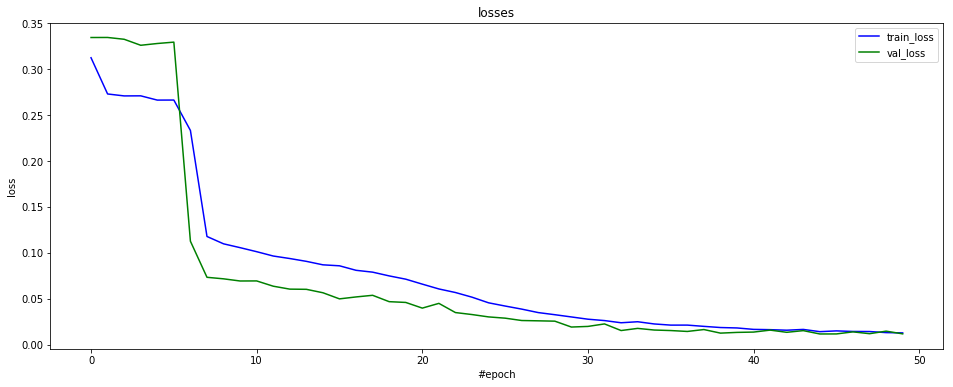

Finished!


In [103]:
generator, epoch_history = train(generator, X_tr, X_te, y_tr, y_te, 
                                 batchsize=1, n_epochs = 50)

Epoch 50 of 50 took 3.620s
current train loss: 0.013189128920566872
current val loss: 0.012273742817342281


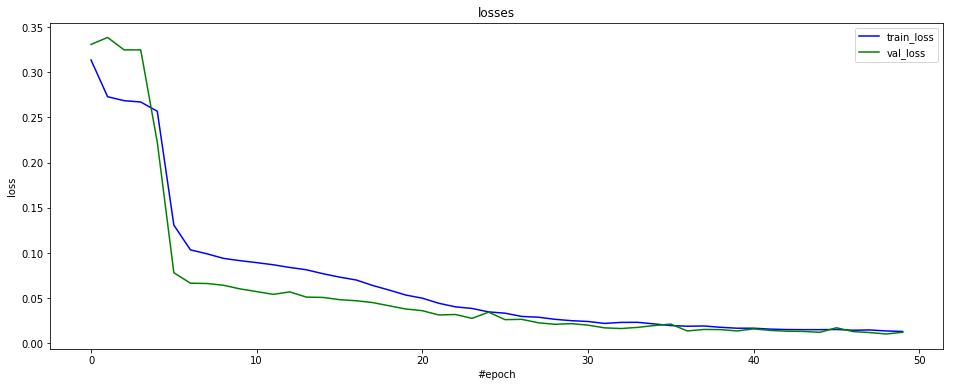

Finished!


In [32]:
generator, epoch_history = train(generator, X_tr, X_te, y_tr, y_te, 
                                 batchsize=1, n_epochs = 50)

In [33]:
# generator.eval

## Save/load the model

In [34]:
# from model import Generator, iterate_minibatches, compute_loss, train
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_canonical'))
# the_model = Generator()
# the_model.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))

In [35]:
# print(the_model)
# for i in list(the_model.note_ax.note_lstm.parameters()):
#     print(i.shape)

In [36]:
# dummy_note = Variable(torch.Tensor(train_data[0]))
# chosen = Variable(torch.Tensor(train_data[1]))

# # output = generator.forward(dummy_note, chosen)
# output = the_model.forward(dummy_note, chosen)

# print('dummy_time_features :', output.shape)
# output[0][0][3], output2[0][0][3]

# Canonical

In [104]:
generator.cuda()
write_file('output/canonical_test', generate(generator, 8))

  0%|          | 0/128 [00:00<?, ?it/s]

Generating with no styles:


100%|██████████| 128/128 [00:18<00:00,  6.92it/s]

Writing file out/samples/output/canonical_test_0.mid


In [93]:
# midi_file = 'out/samples/output/canonical_test_0.mid'
# play_music(midi_file)